In [8]:
import networkx as nx
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import nltk
import community.community_louvain as community
import squarify
import seaborn as sb
from nltk.corpus import stopwords
import matplotlib.patches as mpatches
nltk.download("stopwords")
lemmatizer = nltk.stem.WordNetLemmatizer()
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luxonice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
with open("LargeData/Graph.pkl", "rb") as file:
    G = pkl.load(file)

# Make GCC
#G = nx.subgraph(G, [node for node in G.nodes()][:1000])
#G = nx.subgraph(G,max(nx.weakly_connected_components(G), key=len)) # GCC

G = nx.MultiGraph(G)

# Remove nodes with out-degree 0
G.remove_nodes_from(list(nx.isolates(G)))

In [27]:
# Get node attributes for authors and their flair
authors = list(G.nodes())
flairs = nx.get_node_attributes(G, 'flair')

# Dataframe with authors and flairs
df_flairs = pd.DataFrame(list(flairs.items()), columns=['Author', 'Flair'])

trials = 100
number_of_communities = np.zeros(trials)
for i in range(trials):
    if i % 10 == 0:
        print(i)
    partition = community.best_partition(G)
    number_of_communities[i] = len(set(partition.values()))

med = int(np.median(number_of_communities))
# Print the number of communities
print("Mean number of communities:", np.mean(number_of_communities))
print("Median number of communities:", int(np.median(number_of_communities)))

0
10
20
30
40
50
60
70
80
90
Mean number of communities: 99.04
Median number of communities: 99


In [28]:
def modularity(G,partition):
    modularity_vals = []
    L = G.number_of_edges()
    for i in range(len(partition)):
        Lc = G.subgraph(partition[i]).number_of_edges()
        kc = 0
        for node in partition[i]:
            kc += G.degree(node)
        modularity_vals.append(Lc/L - (kc/(2*L))**2)
    return sum(modularity_vals)

while True:
    partition = community.best_partition(G)
    if len(set(partition.values())) == med:
        break

In [30]:
# Create dataframe with author and community
df_community = pd.DataFrame(list(partition.items()),columns = ['Author','Community'])
df_community = df_community.sort_values(by='Community')

# Merge the community information with flair information based on authors
merged_df = pd.merge(df_community, df_flairs, on='Author')

# Overall flair distribution across all communities
flair_counts = merged_df.groupby('Flair')['Author'].nunique()

In [31]:
# Save df_community as pkl
with open('LargeData/df_community.pickle', 'wb') as f:
    pkl.dump(df_community, f)

In [18]:
specific_community = 1
community_data = merged_df[merged_df['Community'] == specific_community]
community_flair_counts = community_data['Flair'].value_counts()

print("Top flair in community 1: ")
print(community_flair_counts[:3])

Top flair in community 1: 
Flair
intp    757
infp    543
intj    510
Name: count, dtype: int64


Communities plot

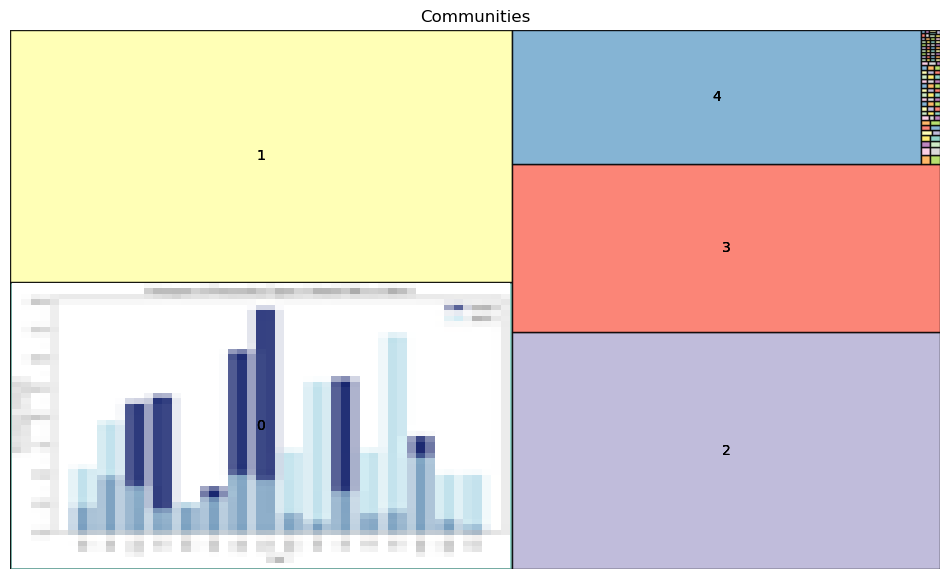

In [69]:
number_of_unique_communities = len(df_community['Community'].unique())
number_of_members_in_each_community = df_community['Community'].value_counts().values

labels = [str(i) for i in range(number_of_unique_communities)]
labels[5:] = ['' for i in range(number_of_unique_communities-5)]
sizes = df_community['Community'].value_counts().values

fig, ax = plt.subplots(figsize=(12,7))
squarify.plot(sizes=sizes,alpha=.8,label=labels,color=sb.color_palette("Set3", number_of_unique_communities),ec='black',ax=ax)

# get coordinates of each rectangle
allrectangles = squarify.plot(sizes=sizes,label=labels,alpha=.8,color=sb.color_palette("Set3", number_of_unique_communities),ec='black',ax=ax)
rectangles = []
for rect in allrectangles.patches:
    x, y, w, h = rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height()
    rectangles.append((x, y, w, h))

# Path to the word cloud images
word_cloud_paths = ["Images/output.png"]

# Iterate through each rectangle and overlay the word cloud
for i, (size, word_cloud_path) in enumerate(zip(sizes, word_cloud_paths)):
    # Get the coordinates of the rectangle
    x, y, dx, dy = rectangles[i]
    edge_width = 0.5
    x += edge_width/2
    y += edge_width/2
    dx -= edge_width
    dy -= edge_width

    # Load the word cloud image
    word_cloud_img = Image.open(word_cloud_path)

    # Resize the word cloud image to fit the rectangle
    word_cloud_img = word_cloud_img.resize((int(dx), int(dy)))

    # Overlay the word cloud on the plot
    ax.imshow(word_cloud_img, extent=(x, x + dx, y, y + dy), aspect='auto', zorder=2)

squarify.plot(sizes=sizes,label=labels,alpha=0,color=sb.color_palette("Set3", number_of_unique_communities),ec='black',ax=ax)
plt.title('Communities')
plt.axis('off')
plt.show()

TypeError: cannot unpack non-iterable float object

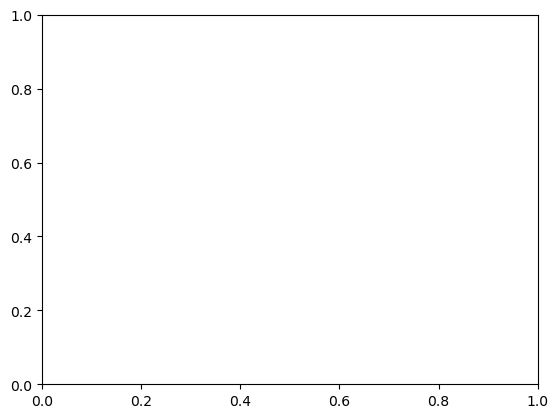

In [43]:
import matplotlib.pyplot as plt
import squarify
from PIL import Image

# Sample data for Squarify plot
sizes = [25, 40, 20, 15]

# Create Squarify plot
fig, ax = plt.subplots()

# Path to the word cloud images
word_cloud_paths = ["Images/output.png"]

# Iterate through each rectangle and overlay the word cloud
for i, (size, word_cloud_path) in enumerate(zip(sizes, word_cloud_paths)):
    # Get the coordinates of the rectangle
    x, y, dx, dy = squarify.normalize_sizes([size], dx=1, dy=1)[0]

    # Load the word cloud image
    word_cloud_img = Image.open(word_cloud_path)

    # Resize the word cloud image to fit the rectangle
    word_cloud_img = word_cloud_img.resize((int(dx), int(dy)))

    # Overlay the word cloud on the plot
    ax.imshow(word_cloud_img, extent=(x, x + dx, y, y + dy), aspect='auto', zorder=2)

# Remove axis labels
ax.axis("off")

# Show the plot
plt.show()


In [45]:
print('number of communities with length = 1:', len([i for i in number_of_members_in_each_community if i == 1]))

number of communities with length = 1: 42


Graph over communities and the flairs active in those communities compared to the overall distributions of the flairs in the MBTI forum

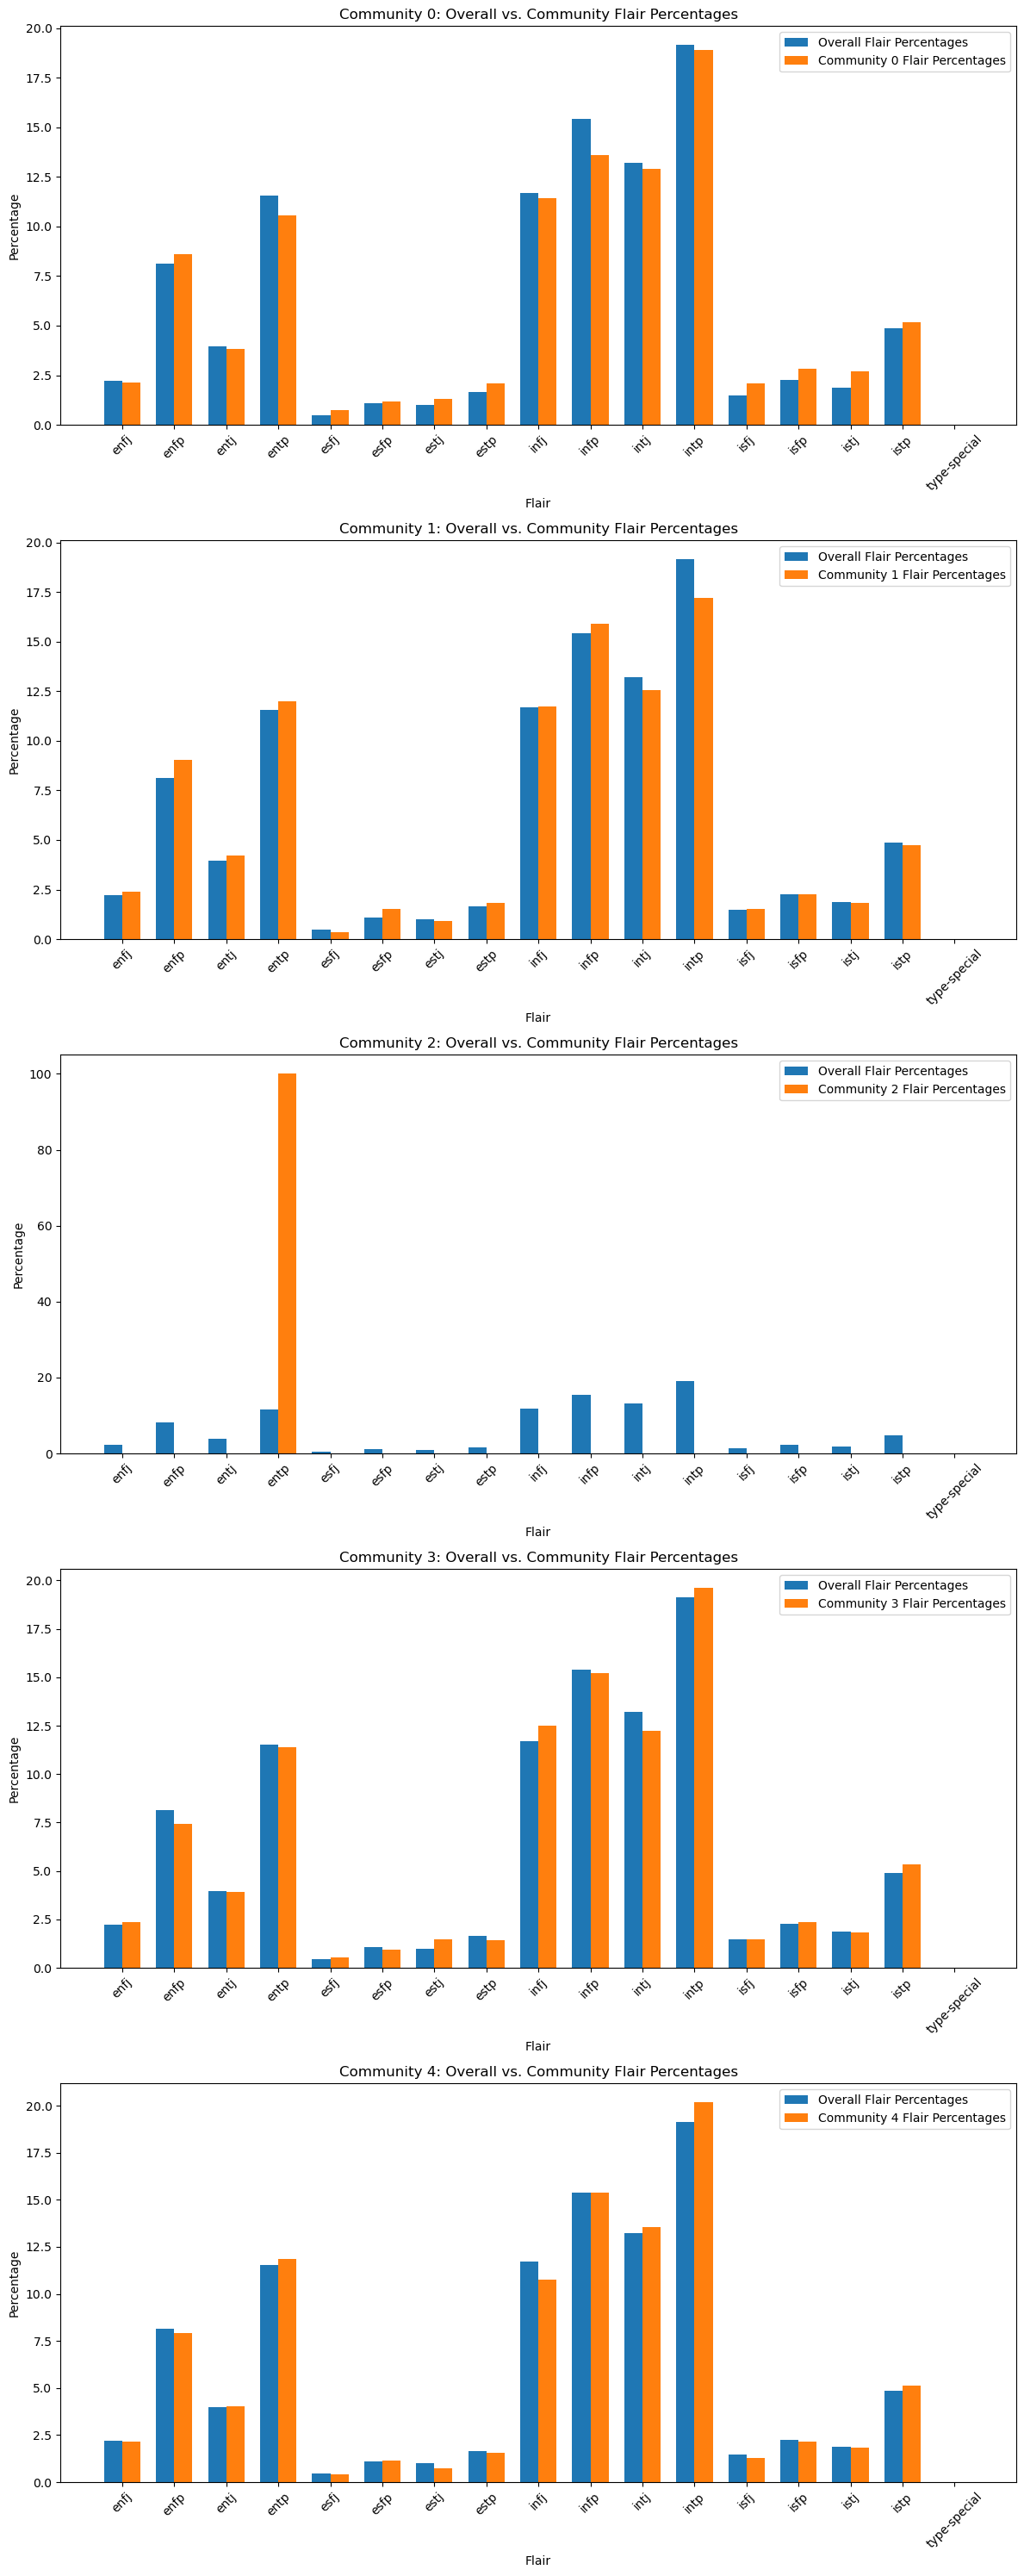

In [47]:
# Getting unique communities
unique_communities = merged_df['Community'].unique()[:5]

# Setting up subplots to display plots for each community
num_communities = len(unique_communities)
num_comminties = 5
fig, axes = plt.subplots(num_communities, 1, figsize=(12, 6 * num_communities))

for idx, specific_community in enumerate(unique_communities):
    
    # Overall flair counts across all communities
    flair_counts = merged_df.groupby('Flair')['Author'].nunique()

    # Flair counts within a specific community
    community_data = merged_df[merged_df['Community'] == specific_community]
    community_flair_counts = community_data['Flair'].value_counts()

    # Calculate percentages
    total_flair_counts = flair_counts.sum()
    community_percentages = (community_flair_counts / community_flair_counts.sum()) * 100

    # Bar plot for overall flair counts and community flair counts side by side
    bar_width = 0.35
    index = np.arange(len(flair_counts))

    ax = axes[idx]
    rects1 = ax.bar(index, (flair_counts / total_flair_counts) * 100, bar_width, label='Overall Flair Percentages')
    rects2 = ax.bar(index + bar_width, community_percentages.reindex(flair_counts.index, fill_value=0).values,
                    bar_width, label=f'Community {specific_community} Flair Percentages')

    ax.set_xlabel('Flair')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Community {specific_community}: Overall vs. Community Flair Percentages')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(flair_counts.index, rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# find the authors from the graph in data
authors = list(G.nodes())
flairs = nx.get_node_attributes(G,'flair')

# Make dataframe with authors and flairs
df_flairs = pd.DataFrame(list(flairs.items()),columns = ['Author','Flair'])

# Compute modularity for the authors divided into flairs
modularity_flairs = modularity(G, [df_flairs[df_flairs['Flair']==i]['Author'].values for i in df_flairs['Flair'].unique()])
print('Modularity Flairs:',modularity_flairs)

Modularity Flairs: 0.05613803884108743


: 

: 

: 

: 

In [33]:
# Modularity of communities
modularity_communities = modularity(G, [df_community[df_community['Community']==i]['Author'].values for i in range(len(df_community['Community'].unique()))])
print('Modularity Communities:',modularity_communities)

Modularity Communities: 0.5215404412868635


In [21]:
# Modularity of extroverts (flair starts with e)  vs introverts (flair starts with i)
modularity_extroverts = modularity(G, [df_flairs[df_flairs['Flair'].str.startswith('e')]['Author'].values,df_flairs[df_flairs['Flair'].str.startswith('i')]['Author'].values])
print('Modularity Extroverts vs Introverts:',modularity_extroverts)

Modularity Extroverts vs Introverts: 0.03971722884624625


In [22]:
# Modularity of intuitive (2nd letter of flair is n)  vs observing (2nd letter of flair is s)
modularity_thinking = modularity(G, [df_flairs[df_flairs['Flair'].str[1]=='n']['Author'].values,df_flairs[df_flairs['Flair'].str[1]=='s']['Author'].values])
print('Modularity Thinking vs Feeling:',modularity_thinking)

Modularity Thinking vs Feeling: 0.02830261767052892


In [23]:
# Modularity of thinking (3rd letter of flair is t)  vs feeling (3rd letter of flair is f)
modularity_thinking = modularity(G, [df_flairs[df_flairs['Flair'].str[2]=='t']['Author'].values,df_flairs[df_flairs['Flair'].str[2]=='f']['Author'].values])
print('Modularity Thinking vs Feeling:',modularity_thinking)

Modularity Thinking vs Feeling: 0.052344570569377524


In [24]:
# Modularity of prospecting (last letter of flair is p)  vs judging (last letter of flair is j)
modularity_thinking = modularity(G, [df_flairs[df_flairs['Flair'].str[3]=='p']['Author'].values,df_flairs[df_flairs['Flair'].str[3]=='j']['Author'].values])
print('Modularity Thinking vs Feeling:',modularity_thinking)

Modularity Thinking vs Feeling: 0.043270753499446604


In [ ]:
# Modularity of a random 50/50 split
random.seed(42)
random.shuffle(authors)
modularity_random = modularity(G, [authors[:len(authors)//2],authors[len(authors)//2:]])
print('Modularity Random:',modularity_random)

Modularity Random: 0.0154838985554899


: 

: 

: 

: 

: 

: 

: 

: 